# Project 1 Kevin Steiner Test Run

The model selected was a random forest regressor. You can just run the cells in this order. In the beginning I define some functions and prepare the data to run the ML model

In [10]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import holidays
from sklearn import  metrics
  
test_data = pd.read_csv('testData_2019_NorthTower.csv')
test_data.rename(columns = {'Date':'time'}, inplace = True)
test_data.rename(columns = {'North Tower (kWh)':'Power_kW'}, inplace = True)
test_data['time'] = pd.to_datetime(test_data['time'], format="%Y-%m-%d %H:%M")
test_data = test_data.set_index('time', drop=True)
test_data.head()

def ml_metrics(pred, check):
    MAE=metrics.mean_absolute_error(check,pred) 
    MBE=np.mean(check-pred) 
    MSE=metrics.mean_squared_error(check,pred)  
    RMSE= np.sqrt(metrics.mean_squared_error(check,pred))
    cvRMSE=RMSE/np.mean(check)
    NMBE=MBE/np.mean(check)
    r2 = metrics.r2_score(check,pred)
    print('R2     :',r2)

    print('MAE    :', MAE)
    print('MBE    :', MBE)
    print('MSE    :', MSE)
    print('RMSE   :', RMSE)
    print('cvRMSE :', cvRMSE)
    print('NMBE   :', NMBE)

In [11]:
def add_holiday_to_dataframe(dataframe, inplace = False):
  holidays_pt = holidays.PT(subdiv='11', years=[2017,2018,2019])
  if inplace == True: new_frame = dataframe
  else: new_frame = dataframe.copy()
  #print(new_frame.index)
  new_frame['Holiday'] = new_frame.index
  new_frame['Holiday'] = new_frame['Holiday'].dt.date.isin(holidays_pt)
  return new_frame
def add_weekday_to_dataframe(dataframe, inplace = False):
  if inplace == True: new_frame = dataframe
  else: new_frame = dataframe.copy()

  new_frame['Weekday'] = new_frame.index
  new_frame['Weekday'] = new_frame.index.dayofweek
  return new_frame
def add_dayhour_to_dataframe(dataframe, inplace = False):
  if inplace == True: new_frame = dataframe
  else: new_frame = dataframe.copy()

  new_frame['Hour'] = new_frame.index
  new_frame['Hour'] = new_frame.index.hour
  return new_frame
def add_month_to_dataframe(dataframe, inplace = False):
  if inplace == True: new_frame = dataframe
  else: new_frame = dataframe.copy()

  new_frame['Month'] = new_frame.index
  new_frame['Month'] = new_frame.index.month
  return new_frame
def power_minus_n(dataframe, n=1, inplace = False):
  if inplace == True: new_frame = dataframe
  else: new_frame = dataframe.copy()

  new_frame['Power -'+str(n)] = new_frame['Power_kW'].shift(1)
  return new_frame

In [12]:
augumented_data = test_data.copy()
augumented_data = (
  augumented_data.pipe(add_holiday_to_dataframe)
  .pipe(add_weekday_to_dataframe)
  .pipe(add_dayhour_to_dataframe)
  .pipe(add_month_to_dataframe)
  .pipe(power_minus_n,n=1)
).dropna()
augumented_data.head()

,Power_kW,temp_C,HR,windSpeed_m/s,windGust_m/s,pres_mbar,solarRad_W/m2,rain_mm/h,rain_day,Holiday,Weekday,Hour,Month,Power -1
time,,,,,,,,,,,,,,
2019-01-01 01:00:00,43.221,10.377500,62.836667,0.0,0.0,1031.000000,1.728667,0.0,0.0,True,1,1,1,43.537
2019-01-01 02:00:00,43.231,10.260833,61.720000,0.0,0.0,1031.083333,2.674750,0.0,0.0,True,1,2,1,43.221
2019-01-01 03:00:00,43.434,9.666667,63.893333,0.0,0.0,1031.083333,2.444250,0.0,0.0,True,1,3,1,43.231
2019-01-01 04:00:00,42.527,8.640833,68.034167,0.0,0.0,1031.000000,3.056333,0.0,0.0,True,1,4,1,43.434
2019-01-01 05:00:00,42.700,9.093333,63.193333,0.0,0.0,1031.000000,2.426417,0.0,0.0,True,1,5,1,42.527


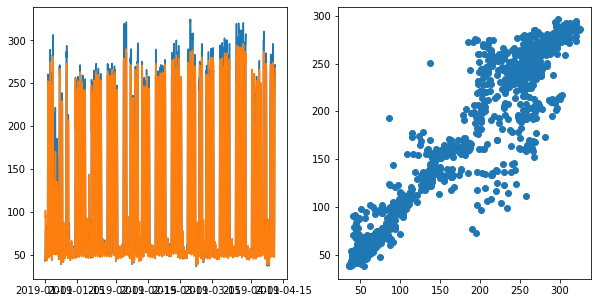

R2     : 0.9381909305646792
MAE    : 11.527218132682389
MBE    : 4.652550709810639
MSE    : 492.81727968015036
RMSE   : 22.199488275186667
cvRMSE : 0.18531419866550497
NMBE   : 0.03883799913995699


In [13]:
#Load LR model
with open('final_model.pkl','rb') as file:
    final_model=pickle.load(file)

featurelist_final = ['Power_kW', 'HR', 'pres_mbar', 'rain_mm/h', 'solarRad_W/m2', 'temp_C',
       'windGust_m/s', 'windSpeed_m/s', 'Holiday', 'Weekday', 'Hour', 'Month', 'Power -1']

df = augumented_data[featurelist_final]

t = df.index


Z = df.values
Y = df['Power_kW'].values
X = df.drop(columns=['Power_kW']).values


final_pred = final_model.predict(X)


plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(t,Y)
plt.plot(t,final_pred)

plt.subplot(1,2,2)
plt.scatter(Y,final_pred)

plt.show()
ml_metrics(final_pred,Y)

The standart of ASHRAE and IPMVP are a R2 score of R2 > 0.75. Which this model should fulfill. It also has a cvRMSE below 0.20 and an NMBE below 0.05. This errors of this model, therefore, are below the ASHRAE and IPMVP standards